# pandas 进阶修炼 ｜早起Python
<br>

**pandas进阶修炼系列由公众号【早起Python & 可视化图鉴】 原创**

**转载及其他形式合作请与我们联系（微信号`sshs321`)，未经授权严禁搬运及二次创作，侵权必究！**


本习题基于 `pandas` 版本 `1.1.3`，所有内容应当在 `Jupyter Notebook` 中执行以获得最佳效果。

不同版本之间写法可能会有少许不同，如若碰到此情况，你应该学会如何自行检索解决。

## 实战｜客户细分模型



<br>


**<font color = '#5172F0'><font size=3.5>必读👇👇👇</font>**
    
**本习题微信公众号「<font color ='#F77802'>数据STUDIO</font>」号主云朵君友情提供，授权公众号「早起Python」二次整理发布**
   

客户细分模型是将整体会员划分为不同的细分群体或类别，然后基于细分群体做管理、营销和关怀。客户细分模型常用于整体会员的宏观性分析以及探索性分析，通过细分建立初步认知，为下一步的分析和应用提供基本认知。

我们将使用电子商务用户购买数据集，并尝试开发一个模型，允许我们做两件事:

1. **对客户进行细分。**
2. **预计下一年新客户将会购买哪些产品，这是从它的第一次购买，通过分配适当的集群/段**

<br>  
    
**<font color = '#5172F0'><font size=3.5>更多资源👇👇👇</font>**   
    
如果需要获得与本案例更多的资源，可以微信搜索公众号「<font color ='#F77802'>数据STUDIO</font>」关注，或者点击下方文章链接查看！

- [一个企业级数据挖掘实战项目｜客户细分模型（上）](https://mp.weixin.qq.com/s/lp0We7FWFv7cCGiEUnauFA)  
- [一个企业级数据挖掘实战项目｜客户细分模型（下）](https://mp.weixin.qq.com/s/RC74jRWL3ADnVRlVjeEwTQ)

<br>
    
**<font color = '#5172F0'><font size=3.5>注意👇👇👇</font>**
    
**注意1**：为了尽可能还原一次真实的数据分析项目，在食用本notebook时，可能会出现我们没有提示（解决方案）的报错，你应学会如何自行解决！

**注意2**：由于本案例后半部分涉及内容大多为机器学习相关，因此将不做习题使用，提供用于pandas操作练习的部分仅到25题为止！
   
**注意3**：为了尽可能让大家理解题意，我将保留每一题的运行结果，该结果仅供参考，只要完成题目要求，在样式和文字上无需保持一致！

## 初始化

<br>

该 `Notebook` 版本为**纯习题版**

如果需要答案或者提示，可以微信搜索公众号「早起Python」获取！

## 导入依赖包

执行以下代码来导入本项目使用到的相关库

**如果有任何导入相关的错误，大概率是因为你没有安装，根据报错提示使用 pip 安装即可。**

**导入库相关的问题不应在知识星球或者微信群进行提问！**

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
import plotly.express as px
warnings.filterwarnings("ignore")
%matplotlib inline

##   数据准备

执行下面的代码来读取本项目所用到源数据

In [3]:
df_initial = pd.read_csv('./data.csv')
print('Dataframe dimensions:', df_initial.shape)
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

Dataframe dimensions: (284709, 8)


## 数据预览

### 1 - 修改列名

将 `df_initial` 的列名修改为 `'订单编号', '库存代码', '描述', '数量', '订单日期', '单价', '客户ID', '国家'`

### 2 - 数据查看

查看 `df_initial` 的前 5 行

订单编号   库存代码                                  描述  数量                订单日期  \
0  559518  21989      PACK OF 20 SKULL PAPER NAPKINS   6 2011-07-08 16:11:00   
1  559518  22055  MINI CAKE STAND  HANGING STRAWBERY   1 2011-07-08 16:11:00   
2  559518  22179             SET 10 NIGHT OWL LIGHTS   1 2011-07-08 16:11:00   
3  559518  22297           HEART IVORY TRELLIS SMALL   1 2011-07-08 16:11:00   
4  559518  22352   LUNCH BOX WITH CUTLERY RETROSPOT    1 2011-07-08 16:11:00   

      单价  客户ID              国家  
0   1.63   NaN  United Kingdom  
1   3.29   NaN  United Kingdom  
2  13.29   NaN  United Kingdom  
3   2.46   NaN  United Kingdom  
4   4.96   NaN  United Kingdom

## 探索性数据分析

### 3 - 数据检查

缺失值分析与处理是指对原始数据中缺失的数据项进行预处理，以免影响模型精度和稳定性。

-> 现在，显示有关列类型和空值数量的信息

---------- 显示有关列类型和空值数量的信息 ----------


订单编号    库存代码       描述     数量            订单日期       单价     客户ID  \
字段类型     object  object   object  int64  datetime64[ns]  float64  float64   
空值量(nb)       0       0      502      0               0        0    61357   
空值率(%)        0       0  0.17632      0               0        0  21.5508   

             国家  
字段类型     object  
空值量(nb)       0  
空值率(%)        0

### 4 - 删除缺失值

从上面缺失值分析结果看到，客户ID 约22%的数据记录是空的，这意味着有约22%的数据记录没有分配给任何客户。而我们不可能把这些记录的值映射到任何客户。所以这些对于目前是没有用的，因此我们可以将其删除。

-> 现在删除缺失值，并再次查看数据维度


Dataframe维度: (223352, 8)


订单编号    库存代码      描述     数量            订单日期       单价     客户ID  \
字段类型     object  object  object  int64  datetime64[ns]  float64  float64   
空值量(nb)       0       0       0      0               0        0        0   
空值率(%)        0       0       0      0               0        0        0   

             国家  
字段类型     object  
空值量(nb)       0  
空值率(%)        0

### 5 - 重复值处理

查看重复的数据条目并删除

重复的数据条目: 3175


### 6 - 探索数据属性｜国家

查看表中国家数量

表中国家数量: 32


### 7 - 数据可视化

对上一题得到的国家数量进行可视化

### 8 - 数据排序

对国家按照订单量进行排序

---------- 按国家订单量计算并排序 ----------
                      国家   国家订单量
30        United Kingdom  195468
12               Germany    5020
11                France    4633
8                   EIRE    4592
25                 Spain    1326
19           Netherlands    1126
27           Switzerland    1095
2                Belgium    1072
22              Portugal     847
20                Norway     708
0              Australia     587
16                 Italy     491
4        Channel Islands     389
10               Finland     363
1                Austria     274
28                   USA     269
5                 Cyprus     259
26                Sweden     241
15                Israel     229
7                Denmark     205
31           Unspecified     169
21                Poland     154
24             Singapore     111
17                 Japan     107
3                 Canada      83
18                 Malta      80
14               Iceland      80
13                Greece      61
23       

### 9 - 数据转换

将上一题查看的结果转换为 dataframe

国家   国家订单量
30  United Kingdom  195468
12         Germany    5020
11          France    4633
8             EIRE    4592
25           Spain    1326

### 10 - 数据可视化

将国家根据订单量进行可视化

### 11 - 探索数据属性｜客户和产品

查看表中产品、交易、客户数量

产品     交易    客户
数量  3182  11068  3341

### 12 - 探索数据属性｜客户和产品

查看客户id、订单号、产品数量汇总

客户ID    订单编号  产品数量
0  12347  562032    22
1  12347  573511    47
2  12347  581180    11
3  12348  568172     3
4  12349  577609    73
5  12352  567505    18
6  12352  568699    14
7  12352  574275    15
8  12356  576895     2
9  12357  574740   131

### 13 - 数据抽样

从上一题的结果，随机抽出 5 个样本

客户ID     订单编号  产品数量
1793  13189   563440    18
3850  14329   578070     1
6332  15572   563952    40
6686  15802  C560653     1
6874  15906   569222    54

### 14 - 数据查询｜取消订单分析

对取消订单的客户进查询与汇总

客户ID     订单编号  产品数量  取消订单量
13  12359  C580165     4      1
23  12362  C563752     3      1
24  12362  C579178     3      1
38  12375  C581071     1      1
44  12380  C572532     1      1

取消订单数量: 1686/11068 (15.23%) 


### 15 - 数据排序

将 df_initial 依据客户id 升序排列，并随机抽样 5 条数据

订单编号   库存代码                                 描述  数量  \
90466   567327  22996  TRAVEL CARD WALLET VINTAGE TICKET  24   
166594  573155  21932    SCANDINAVIAN PAISLEY PICNIC BAG  10   
132479  570488  21703            BAG 125g SWIRLY MARBLES   1   
68442   565447  22979            PANTRY WASHING UP BRUSH  12   
236094  578225  23313          VINTAGE CHRISTMAS BUNTING   5   

                      订单日期    单价     客户ID              国家  
90466  2011-09-19 14:43:00  0.42  13102.0  United Kingdom  
166594 2011-10-28 08:34:00  1.65  13632.0  United Kingdom  
132479 2011-10-10 17:12:00  0.83  14096.0  United Kingdom  
68442  2011-09-04 15:20:00  1.45  14107.0  United Kingdom  
236094 2011-11-23 11:51:00  4.95  17700.0  United Kingdom

### 16 - 数据查询

根据上一题结果，查询订单编号包含 '579178'和'C579178'的订单详情

订单编号   库存代码                                   描述  数量  \
250167  C579178  22943  CHRISTMAS LIGHTS 10 VINTAGE BAUBLES  -3   
250165  C579178  22941         CHRISTMAS LIGHTS 10 REINDEER  -2   
250166  C579178  22942          CHRISTMAS LIGHTS 10 SANTAS   -2   

                      订单日期    单价     客户ID       国家  
250167 2011-11-28 14:55:00  4.95  12362.0  Belgium  
250165 2011-11-28 14:55:00  8.50  12362.0  Belgium  
250166 2011-11-28 14:55:00  8.50  12362.0  Belgium

### 17 - 数据查询

查询客户ID为12830的订单详情

订单编号   库存代码                                  描述   数量  \
16735   C560869      D                            Discount   -1   
25724    561671  22693  GROW A FLYTRAP OR SUNFLOWER IN TIN  576   
25725    561671  22550                    HOLIDAY FUN LUDO   72   
25726    561671  21912            VINTAGE SNAKES & LADDERS  144   
25727    561671  23229           VINTAGE DONKEY TAIL GAME    72   
25728    561671  22548        HEADS AND TAILS SPORTING FUN  144   
25729    561671  21790                  VINTAGE SNAP CARDS  288   
25730    561671  22536          MAGIC DRAWING SLATE PURDEY  192   
25731    561671  22535        MAGIC DRAWING SLATE BUNNIES   192   
25732    561671  22533    MAGIC DRAWING SLATE BAKE A CAKE   192   
25733    561671  22532      MAGIC DRAWING SLATE LEAP FROG   192   
25734    561672  21891    TRADITIONAL WOODEN SKIPPING ROPE  576   
76452    566207  21703             BAG 125g SWIRLY MARBLES  864   
76453    566207  22536          MAGIC DRAWING SLATE PURDEY  192   
76454    566207  22535        MAGIC DRAWING SLATE BUNNIES   192   
76455    566207  22533    MAGIC DRAWING SLATE BAKE A CAKE   192   
76456    566207  22532      MAGIC DRAWING SLATE LEAP FROG   192   
76457    566207  21790                  VINTAGE SNAP CARDS  360   
76458    566207  22548        HEADS AND TAILS SPORTING FUN  216   
76459    566207  22550                    HOLIDAY FUN LUDO   72   
76460    566207  23229           VINTAGE DONKEY TAIL GAME    72   
176704   574012  21703             BAG 125g SWIRLY MARBLES  864   
176705   574012  21790                  VINTAGE SNAP CARDS  288   

                      订单日期     单价     客户ID              国家  
16735  2011-07-21 14:32:00  66.24  12830.0  United Kingdom  
25724  2011-07-28 17:17:00   0.86  12830.0  United Kingdom  
25725  2011-07-28 17:17:00   2.62  12830.0  United Kingdom  
25726  2011-07-28 17:17:00   2.62  12830.0  United Kingdom  
25727  2011-07-28 17:17:00   2.62  12830.0  United Kingdom  
25728  2011-07-28 17:17:00   0.85  12830.0  United Kingdom  
25729  2011-07-28 17:17:00   0.58  12830.0  United Kingdom  
25730  2011-07-28 17:17:00   0.27  12830.0  United Kingdom  
25731  2011-07-28 17:17:00   0.27  12830.0  United Kingdom  
25732  2011-07-28 17:17:00   0.27  12830.0  United Kingdom  
25733  2011-07-28 17:17:00   0.27  12830.0  United Kingdom  
25734  2011-07-28 17:18:00   1.02  12830.0  United Kingdom  
76452  2011-09-09 15:02:00   0.27  12830.0  United Kingdom  
76453  2011-09-09 15:02:00   0.27  12830.0  United Kingdom  
76454  2011-09-09 15:02:00   0.27  12830.0  United Kingdom  
76455  2011-09-09 15:02:00   0.27  12830.0  United Kingdom  
76456  2011-09-09 15:02:00   0.27  12830.0  United Kingdom  
76457  2011-09-09 15:02:00   0.58  12830.0  United Kingdom  
76458  2011-09-09 15:02:00   0.85  12830.0  United Kingdom  
76459  2011-09-09 15:02:00   2.62  12830.0  United Kingdom  
76460  2011-09-09 15:02:00   2.62  12830.0  United Kingdom  
176704 2011-11-02 11:54:00   0.27  12830.0  United Kingdom  
176705 2011-11-02 11:54:00   0.58  12830.0  United Kingdom

### 18 - 数据查询

查询数量小于0的 `'客户ID','数量', '库存代码','描述','单价'`

客户ID                        14808.0
数量                               -1
库存代码                          22655
描述      VINTAGE RED KITCHEN CABINET
单价                            125.0
Name: 279, dtype: object
-------------------------> 假设未完成


### 19 - 数据筛选

本题是为了筛选出需要删除的订单，直接给出代码

In [24]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['取消订单数量'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['数量'] > 0) or col['描述'] == 'Discount': continue        
    df_test = df_initial[(df_initial['客户ID'] == col['客户ID']) &
                         (df_initial['库存代码']  == col['库存代码']) & 
                         (df_initial['订单日期'] < col['订单日期']) & 
                         (df_initial['数量']   > 0)].copy()

    # 没有对应项的取消订单
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
   
    # 有对应项的取消订单
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, '取消订单数量'] = -col['数量']
        entry_to_remove.append(index)        
   
    # 不同的对应项是按顺序存在的:我们删除最后一个
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['数量'] < -col['数量']: continue
            df_cleaned.loc[ind, '取消订单数量'] = -col['数量']
            entry_to_remove.append(index) 
            break      
            
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 3424
doubtfull_entry: 984


### 20 -  数据删除

本题是为了删除部分数据，直接给出代码

In [26]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['数量'] < 0) & (df_cleaned['库存代码'] != 'D')]
print("要删除的记录数量: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

要删除的记录数量: 10


订单编号   库存代码                              描述  数量  \
76464   C566209  23355      HOT WATER BOTTLE KEEP CALM  -5   
80564   C566467  22384         LUNCH BAG PINK POLKADOT -14   
103337  C568232  23007          SPACEBOY BABY GIFT SET  -3   
165413  C573097  23251    VINTAGE RED ENAMEL TRIM MUG  -18   
177723  C574065  22945  CHRISTMAS METAL TAGS ASSORTED  -24   

                      订单日期     单价     客户ID              国家  取消订单数量  
76464  2011-09-09 15:04:00   4.95  16362.0  United Kingdom       0  
80564  2011-09-12 18:04:00   1.65  14688.0  United Kingdom       0  
103337 2011-09-26 11:27:00  16.95  14808.0  United Kingdom       0  
165413 2011-10-27 14:42:00   1.25  15038.0  United Kingdom       0  
177723 2011-11-02 14:43:00   0.85  13271.0  United Kingdom       0

### 21 - 数据筛选

筛选 df_cleaned 表中客户ID等于14048并且库存代码等于22464的数据

Empty DataFrame
Columns: [订单编号, 库存代码, 描述, 数量, 订单日期, 单价, 客户ID, 国家, 取消订单数量]
Index: []

### 22 - 数据筛选｜正则

从上面分析内容中看到，库存代码变量的一些值表示一个特定的交易(D代表Discount)。

下面通过正则表达式寻找只包含字母的代码集，统计出这个变量都有哪些值。

array(['M', 'POST', 'D', 'C2', 'PADS', 'DOT', 'BANK CHARGES'],
      dtype=object)

In [29]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['库存代码'] == code]['描述'].unique()[0]))

M               -> Manual                        
POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
BANK CHARGES    -> Bank Charges                  


### 23 - 数据添加



接下来是衍生变量：每次购买的总价 = 单价 * (订单数量 - 取消订单数量)

-> 新增一列总价，值为 每次购买的总价 = 单价 * (订单数量 - 取消订单数量)

订单编号   库存代码                                   描述  数量  \
171803  573511  22131     FOOD CONTAINER SET 3 LOVE HEART    6   
171761  573511  22375    AIRLINE BAG VINTAGE JET SET BROWN   8   
171762  573511  22371         AIRLINE BAG VINTAGE TOKYO 78  12   
171763  573511  22374      AIRLINE BAG VINTAGE JET SET RED   8   
171764  573511  22252  BIRDCAGE DECORATION TEALIGHT HOLDER  12   

                      订单日期    单价     客户ID       国家  取消订单数量    总价  
171803 2011-10-31 12:25:00  1.95  12347.0  Iceland       0  11.7  
171761 2011-10-31 12:25:00  4.25  12347.0  Iceland       0  34.0  
171762 2011-10-31 12:25:00  3.95  12347.0  Iceland       0  47.4  
171763 2011-10-31 12:25:00  4.25  12347.0  Iceland       0  34.0  
171764 2011-10-31 12:25:00  1.25  12347.0  Iceland       0  15.0

### 24 - 数据分组聚合

数据集中的每一条记录都表示一种产品的价格。而一条订单可以被分成几条记录。因此需要将一条订单中所有价格汇总求和，得到每一个订单总价。

以客户ID和订单编号作为聚合对象，对总价进行求和。
订单日期处理，现将订单日期转换为整数类型，聚合后求平均值，在转换为日期型。
最后筛选出购物车价格大于0的重要记录。

-> 现在，以客户ID和订单编号作为聚合对象，对总价进行求和

接下来处理订单日期和选择

In [32]:

# 处理订单日期
df_cleaned['订单日期_int'] = df_cleaned['订单日期'].astype('int64')
temp = df_cleaned.groupby(by=['客户ID', '订单编号'], as_index=False)['订单日期_int'].mean()
df_cleaned.drop('订单日期_int', axis = 1, inplace = True)
basket_price.loc[:, '订单日期'] = pd.to_datetime(temp['订单日期_int'])

# 重要记录选择
basket_price = basket_price[basket_price['购物车价格'] > 0]
basket_price.sort_values('客户ID')[:6]

客户ID    订单编号    购物车价格                          订单日期
0  12347.0  562032   584.91 2011-08-02 08:48:00.000000000
1  12347.0  573511  1294.32 2011-10-31 12:25:00.000001280
2  12347.0  581180   224.82 2011-12-07 15:52:00.000000000
3  12348.0  568172   310.00 2011-09-25 13:13:00.000000000
4  12349.0  577609  1757.55 2011-11-21 09:51:00.000000256
5  12352.0  567505   366.25 2011-09-20 14:34:00.000000000

### 25 - 数据可视化

对购物车价格进行可视化

## 产品类别分析

<br>

在数据集中，产品是通过变量库存代码唯一标识的。产品的简短描述在变量描述中给出。在这里计划使用后一个变量的内容，即变量描述，以便将产品分组到不同的类别中。

因此这里就涉及到自然语言处理，需要先将简短描述分词后再统计。由于数据集使用的是纯英文数据集，因此这里选用nltk库进行处理。


首先从描述变量中提取有用的信息。因此这里定义了一个函数

这个函数以dataframe作为输入，分析描述列的内容，执行如下操作:

提取产品描述中出现的名称(适当的，常见的)
对于每个名称，提取单词的根，并聚合与这个特定根相关的名称集
每个根出现在数据集中的次数计数
当几个单词被列出为同一个词根时，我认为与这个词根相关的关键字是最短的名字(当有单数/复数变体时，系统地选择单数)

In [35]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = '描述'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # 收集单词或词根
    keywords_select = dict()  # 关联: 词根<->关键字
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:   # 循环获取数据集中每条信息
        if pd.isnull(s): continue  # 过滤是否是空值
        lines = s.lower()          # 小写转换
        tokenized = nltk.word_tokenize(lines)  # 分词
        # 筛选名词词性
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t) # 词根提取
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("变量中关键字'{}'的数量 : {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [36]:
df_produits = pd.DataFrame(df_initial['描述'].unique()).rename(columns = {0:'描述'})
df_produits

描述
0             LUNCH BAG DOLLY GIRL DESIGN
1                  LUNCH BAG SUKI DESIGN 
2                     LUNCH BAG CARS BLUE
3              LUNCH BAG SPACEBOY DESIGN 
4                      REGENCY CAKE SLICE
...                                   ...
3300         RED   ACRYLIC FACETED BANGLE
3301  SET 3 SONG BIRD PAPER EGGS ASSORTED
3302    VINTAGE ENAMEL & CRYSTAL EARRINGS
3303   CREAM HANGING HEART T-LIGHT HOLDER
3304          PAPER CRAFT , LITTLE BIRDIE

[3305 rows x 1 columns]

In [37]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [38]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

变量中关键字'描述'的数量 : 1347


In [39]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

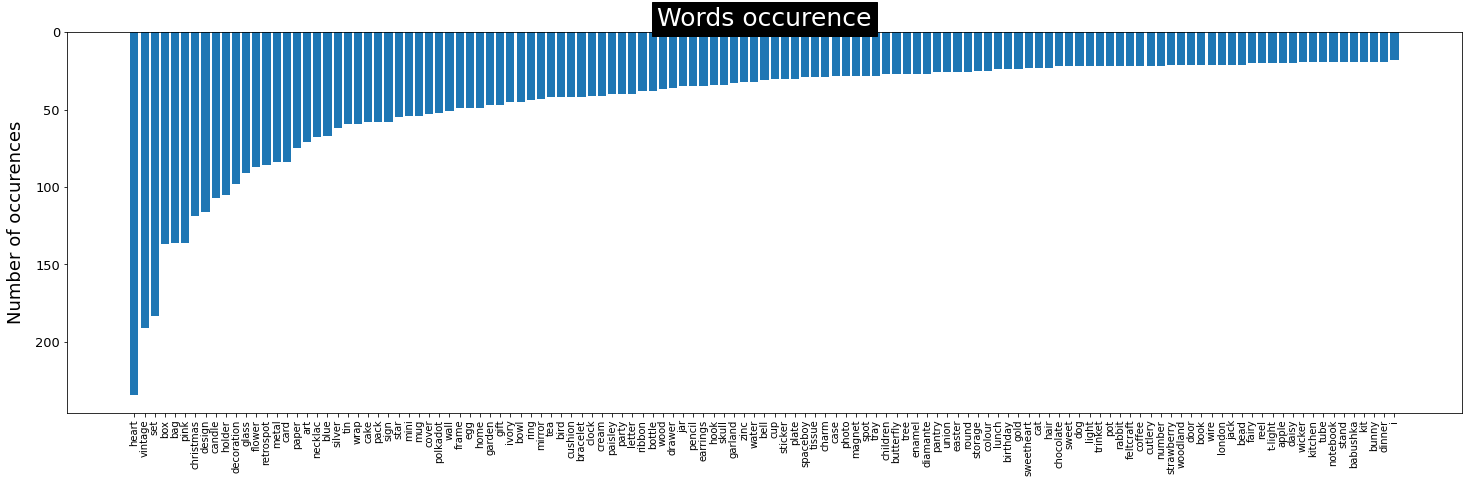

In [40]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(25, 7))
# x_axis = [i[1] if n//2 == 0 else '' for n,i in enumerate(liste[:125])]
x_axis = [i[1] for i in liste[:125]]

y_axis = [k for k,i in enumerate(liste[:125])]
y_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 10,rotation=90)
plt.yticks(fontsize = 13)
plt.xticks(y_axis, y_label)
plt.ylabel("Number of occurences", fontsize = 18, labelpad = 10)
ax.bar(y_axis, x_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

### 定义产品类别

上面结果中，我们获得的列表中包含1400多个关键词，而最频繁的关键词出现在200多种产品中。

然而，在仔细检查列表中内容时发现，有很多名称是无用的，不携带任何有用的信息，比如颜色、标签等。因此，接下来需要将这些词从数据集中删除。

另外，为了更加便捷有效地分析数据，我决定只考虑那些出现超过13次的词。

In [41]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])

list_products.sort(key = lambda x:x[1], reverse = True)
print('保留字:', len(list_products))

保留字: 164


#### 数据编码

首先定义编码规则，将使用上面得到的关键字创建产品组。将矩阵$X$定义如下，其中，如果产品$i$的描述包含单词$j$，则$a_{i,j}$系数为1，否则为0。

In [42]:
liste_produits = df_cleaned['描述'].unique()
#print(liste_produits[0:2])
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
#print(X[0:1])

In [43]:
X

heart  vintage  set  box  bag  christmas  design  candle  holder  \
0         0        0    0    0    1          0       1       0       0   
1         0        0    0    0    1          0       1       0       0   
2         0        0    0    0    1          0       0       0       0   
3         0        0    0    0    1          0       1       0       0   
4         0        0    0    0    0          0       0       0       0   
...     ...      ...  ...  ...  ...        ...     ...     ...     ...   
3293      0        0    0    0    0          0       0       0       0   
3294      0        0    1    0    0          0       0       0       0   
3295      0        1    0    0    0          0       0       0       0   
3296      1        0    0    0    0          0       0       0       1   
3297      0        0    0    0    0          0       0       0       0   

      decoration  ...  picture  bathroom  travel  biscuit  orbit  coaster  \
0              0  ...        0         0       0        0      0        0   
1              0  ...        0         0       0        0      0        0   
2              0  ...        0         0       0        0      0        0   
3              0  ...        0         0       0        0      0        0   
4              0  ...        0         0       0        0      0        0   
...          ...  ...      ...       ...     ...      ...    ...      ...   
3293           0  ...        1         0       0        0      0        0   
3294           0  ...        0         0       0        0      0        0   
3295           0  ...        0         0       0        0      0        0   
3296           0  ...        0         0       0        0      0        0   
3297           0  ...        0         0       0        0      0        0   

      table  purse  tidy  shell  
0         0      0     0      0  
1         0      0     0      0  
2         0      0     0      0  
3         0      0     0      0  
4         0      0     0      0  
...     ...    ...   ...    ...  
3293      0      0     0      0  
3294      0      0     0      0  
3295      0      0     0      0  
3296      0      0     0      0  
3297      0      0     0      0  

[3298 rows x 164 columns]

In [44]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    #print(i)
    #print(col)
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['描述'] == prod]['单价'].mean()
    #print (prix)
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [45]:
X

heart  vintage  set  box  bag  christmas  design  candle  holder  \
0         0        0    0    0    1          0       1       0       0   
1         0        0    0    0    1          0       1       0       0   
2         0        0    0    0    1          0       0       0       0   
3         0        0    0    0    1          0       1       0       0   
4         0        0    0    0    0          0       0       0       0   
...     ...      ...  ...  ...  ...        ...     ...     ...     ...   
3293      0        0    0    0    0          0       0       0       0   
3294      0        0    1    0    0          0       0       0       0   
3295      0        1    0    0    0          0       0       0       0   
3296      1        0    0    0    0          0       0       0       1   
3297      0        0    0    0    0          0       0       0       0   

      decoration  ...  table  purse  tidy  shell  0<.<1  1<.<2  2<.<3  3<.<5  \
0              0  ...      0      0     0      0      0      1      0      0   
1              0  ...      0      0     0      0      0      1      0      0   
2              0  ...      0      0     0      0      0      1      0      0   
3              0  ...      0      0     0      0      0      1      0      0   
4              0  ...      0      0     0      0      0      0      0      1   
...          ...  ...    ...    ...   ...    ...    ...    ...    ...    ...   
3293           0  ...      0      0     0      0      0      1      0      0   
3294           0  ...      0      0     0      0      0      0      1      0   
3295           0  ...      0      0     0      0      0      0      0      1   
3296           0  ...      0      0     0      0      0      0      1      0   
3297           0  ...      0      0     0      0      0      0      1      0   

      5<.<10  .>10  
0          0     0  
1          0     0  
2          0     0  
3          0     0  
4          0     0  
...      ...   ...  
3293       0     0  
3294       0     0  
3295       0     0  
3296       0     0  
3297       0     0  

[3298 rows x 170 columns]

In [51]:
print("{:<8} {:<20} \n".format('范围', '产品数量') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

范围       产品数量                 
--------------------
0<.<1       890                 
1<.<2       817                 
2<.<3       553                 
3<.<5       520                 
5<.<10      395                 
.>10        123                 


#### 创建产品集群

将把产品分组到不同的类中。在二进制编码矩阵的情况下，计算距离最合适的度量是汉明度量。而我们本次使用的也是常用的sklearn的Kmeans方法使用的是欧几里德距离，但在分类变量的情况下，它不是最佳选择。其实可以使用kmodes包以使用汉明度量，小伙伴们可以自行研究。

In [52]:
matrix = X.values
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.11062930220266365
For n_clusters = 4 The average silhouette_score is : 0.13680035318514175
For n_clusters = 5 The average silhouette_score is : 0.15722360950670058
For n_clusters = 6 The average silhouette_score is : 0.1593958217011667
For n_clusters = 7 The average silhouette_score is : 0.15524717712994918
For n_clusters = 8 The average silhouette_score is : 0.16532400447658901
For n_clusters = 9 The average silhouette_score is : 0.16082298271895967


In [54]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.15722360950670058


#### 描述集群的内容

上面对所有订单数据进行了Kmeans聚类，并检查每个类中的元素数量。

In [55]:
pd.Series(clusters).value_counts()

2    890
0    817
4    553
1    520
3    518
dtype: int64

轮廓系数看聚类效果

In [56]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    #plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        
        # 对属于聚类i的样本进行求取轮廓系数，并对其进行排序
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        # color = cm.spectral(float(i) / n_clusters) facecolor=color, edgecolor=color,       
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.8)
        
        # 在轮廓系数图的中间用簇号标记
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
       
        # 为下一个图计算新的y_lower
        y_lower = y_upper + 10  

为了深入了解聚类的效果，常用轮廓系数评价聚类算法模型效果。通过下图可视化地表现聚类效果，参考自sklearn documentation。

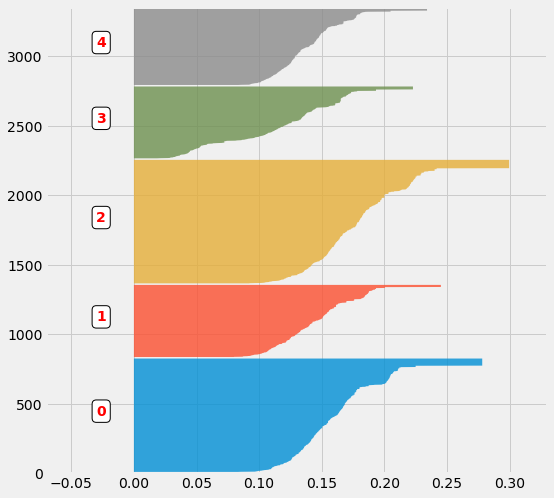

In [57]:
# 定义轮廓系数得分
sample_silhouette_values = silhouette_samples(matrix, clusters)

# 然后画个图
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

词云图看聚类结果

现在我们可以看看每个簇群代表的对象类型。为了获得其内容的全局视图，用每个关键词中最常见的关键词绘制词云图。

先统计关键词出现的频次。

In [59]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']:
            continue
        occurence[i][word] = sum(
            liste_cluster.loc[:, 0].str.contains(word.upper()))

定义绘制词云图函数，并绘制词云图。

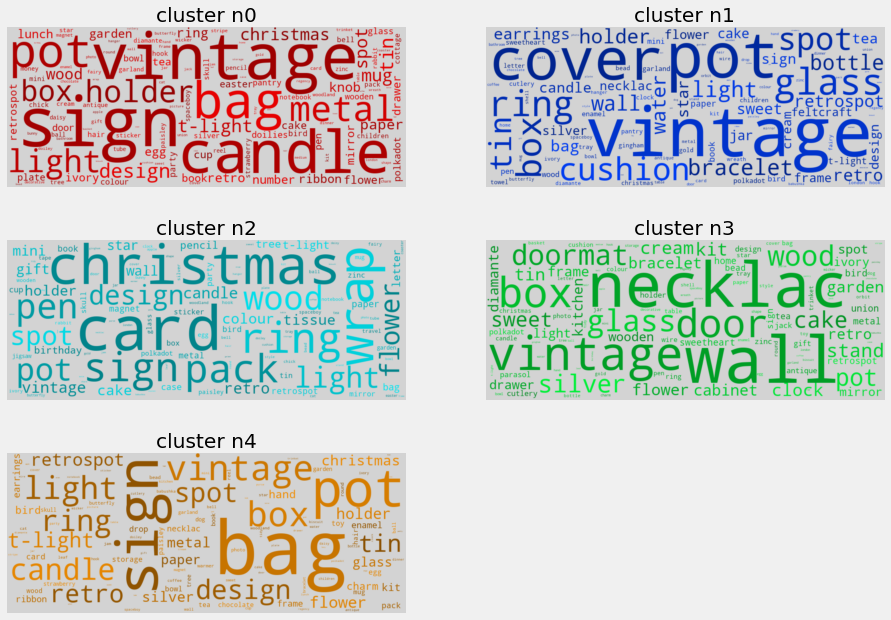

In [60]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4, 2, increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]

    wordcloud = WordCloud(width=1000, height=400, background_color='lightgrey',
                          max_words=1628, relative_scaling=1,
                          color_func=random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n{}'.format(increment-1))

主成分分析

为了使得聚类后的结果能够真正做到有效区分，将含有大量变量的初始矩阵数据，我准备使用PCA主成分分析对其进行处理。

In [63]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

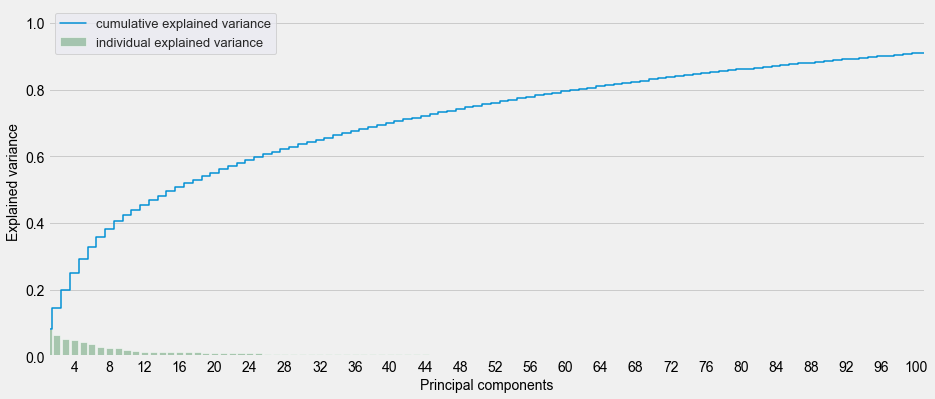

In [64]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%4 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

In [65]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

In [72]:
mat

0         1         2         3         4         5         6  \
0    -0.694697 -0.502087 -0.402300 -0.015645 -0.134910 -0.092386 -0.816670   
1    -0.694697 -0.502087 -0.402300 -0.015645 -0.134910 -0.092386 -0.816670   
2    -0.674510 -0.489402 -0.253610 -0.059910 -0.070595 -0.001697 -0.218246   
3    -0.695574 -0.505652 -0.407102 -0.022640 -0.140822 -0.101423 -0.817048   
4    -0.072765  0.474014  0.387357 -0.645470 -0.289960 -0.129009 -0.116538   
...        ...       ...       ...       ...       ...       ...       ...   
3293 -0.646046 -0.558774 -0.184382 -0.104289 -0.021714 -0.080547 -0.103567   
3294 -0.147559  0.574682 -0.533390  0.417673 -0.241780 -0.236061  0.725320   
3295 -0.088228  0.555444  0.314822 -0.684712 -0.346562 -0.261771 -0.179331   
3296 -0.172224  0.468308  0.705002  1.481149 -0.360210 -0.165677  0.692998   
3297 -0.092891  0.600753 -0.475962  0.465386 -0.134807 -0.183558  0.021023   

             7         8         9  ...        41        42        43  \
0     0.479782  0.925763  0.378673  ...  0.030052  0.017711 -0.007337   
1     0.479782  0.925763  0.378673  ...  0.030052  0.017711 -0.007337   
2    -0.063456 -0.098366  0.269030  ... -0.005228  0.028802 -0.055590   
3     0.505678  0.937625  0.368649  ...  0.098153  0.007523 -0.127605   
4    -0.011100  0.002717 -0.058171  ... -0.098021  0.014567 -0.027248   
...        ...       ...       ...  ...       ...       ...       ...   
3293 -0.125710 -0.174668 -0.157236  ... -0.126087 -0.280886  0.402430   
3294  0.574007 -0.072244 -0.172383  ... -0.017006 -0.090279  0.083534   
3295 -0.098001 -0.353030  0.617371  ... -0.050601 -0.040831 -0.109852   
3296 -0.926818  0.790001  0.226945  ... -0.042508  0.040097 -0.069026   
3297 -0.037381 -0.137496 -0.128500  ...  0.055183  0.111843 -0.190735   

            44        45        46        47        48        49  cluster  
0    -0.082837  0.089630 -0.018919 -0.023605 -0.080682 -0.011958        0  
1    -0.082837  0.089630 -0.018919 -0.023605 -0.080682 -0.011958        0  
2    -0.022883  0.016334 -0.087328 -0.045332 -0.072015  0.019862        0  
3    -0.013895  0.137798 -0.163635 -0.055911 -0.133710  0.007030        0  
4    -0.041997 -0.031249  0.043958 -0.033441  0.030842  0.008306        1  
...        ...       ...       ...       ...       ...       ...      ...  
3293 -0.180487 -0.012696 -0.281980 -0.043231  0.263978  0.018264        0  
3294  0.019725  0.069002 -0.118019 -0.034789  0.026305 -0.007828        4  
3295  0.022256  0.027368  0.019763  0.019685  0.005347 -0.064568        1  
3296  0.177168 -0.017221 -0.061825  0.053196 -0.065519 -0.017126        4  
3297  0.060356  0.051247  0.025174 -0.084649 -0.092556  0.019522        4  

[3298 rows x 51 columns]

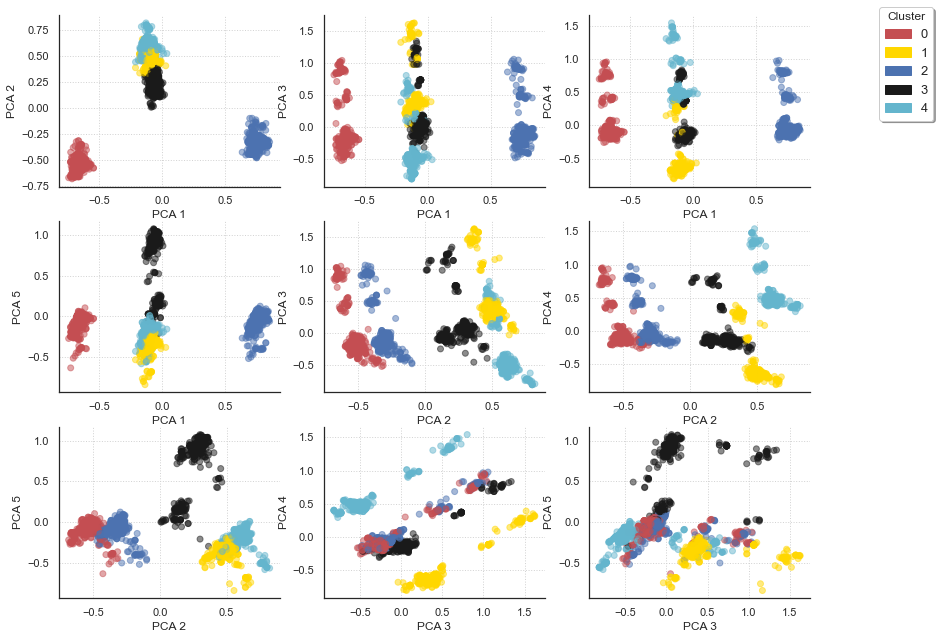

In [73]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0: 'r', 1: 'gold', 2: 'b', 3: 'k', 4: 'c', 5: 'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize=(12, 10))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 5):
        increment += 1
        ax = fig.add_subplot(3, 3, increment)
        ax.scatter(mat[ix], mat[iy], c=label_color, alpha=0.5)
        plt.ylabel('PCA {}'.format(iy+1), fontsize=12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize=12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if increment == 9:
            break
    if increment == 9:
        break

# _______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color=LABEL_COLOR_MAP[i], label=i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9),
           title='Cluster',
           shadow=True, frameon=True, framealpha=1,
           fontsize=13, bbox_transform=plt.gcf().transFigure)  # facecolor = 'lightgrey',

# plt.tight_layout()

## 客户类别

接下来主要分析客户分类，接下来的第一步是将产品分组信息引入数据集。此处创建了分类变量categ_product来表示每个产品的集群。

### 数据预处理

In [74]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 

df_cleaned['categ_product'] = df_cleaned.loc[:, '描述'].map(corresp)
df_cleaned[['订单编号', '描述', 
            'categ_product']][:5]

订单编号                           描述  categ_product
19  559519  LUNCH BAG DOLLY GIRL DESIGN              0
20  559519       LUNCH BAG SUKI DESIGN               0
21  559519          LUNCH BAG CARS BLUE              0
22  559519   LUNCH BAG SPACEBOY DESIGN               0
98  559523           REGENCY CAKE SLICE              1

#### 产品分组

接下来创建categ_N变量( $N \in [0:4]$ )，它包含在每个产品类别中花费的金额。这一步相当于一维数据转二维数据，将五个簇群扩展为五个分类变量，每个变量下存储的是该条记录的价格数据。

In [75]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['单价'] * (df_temp['数量'] - df_temp['取消订单数量'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)


df_cleaned[['订单编号', '描述', 'categ_product', 
            'categ_0', 'categ_1', 'categ_2', 
            'categ_3','categ_4']][:10]

订单编号                                描述  categ_product  categ_0  \
19   559519       LUNCH BAG DOLLY GIRL DESIGN              0   217.50   
20   559519            LUNCH BAG SUKI DESIGN               0   217.50   
21   559519               LUNCH BAG CARS BLUE              0   217.50   
22   559519        LUNCH BAG SPACEBOY DESIGN               0   217.50   
98   559523                REGENCY CAKE SLICE              1     0.00   
99   559523    CAKE STAND 3 TIER MAGIC GARDEN              3     0.00   
100  559523     SET OF 3 HEART COOKIE CUTTERS              0     1.25   
101  559523    72 SWEETHEART FAIRY CAKE CASES              2     0.00   
102  559523           TOAST ITS - I LOVE YOU               0     1.25   
103  559523  RED FLOCK LOVE HEART PHOTO FRAME              2     0.00   

     categ_1  categ_2  categ_3  categ_4  
19      0.00     0.00     0.00      0.0  
20      0.00     0.00     0.00      0.0  
21      0.00     0.00     0.00      0.0  
22      0.00     0.00     0.00      0.0  
98      4.95     0.00     0.00      0.0  
99      0.00     0.00    12.75      0.0  
100     0.00     0.00     0.00      0.0  
101     0.00     0.55     0.00      0.0  
102     0.00     0.00     0.00      0.0  
103     0.00     0.78     0.00      0.0

接下来按照单个订单聚合，将一个订单中所有产品聚合到一条记录中，并记为购物车价格，代表某个特定订单中所有产品的总价。因此，创建了一个新的数据表，其中包含每个订单的购物车价格，以及它在5类产品中分布的方式。

In [76]:
# 购买金额/用户及订单
temp = df_cleaned.groupby(by=['客户ID', '订单编号'], as_index=False)['总价'].sum()
basket_price = temp.rename(columns={'总价': '购物车价格'})

# 订单/产品类别价格的百分比
for i in range(5):
    col = 'categ_{}'.format(i)
    temp = df_cleaned.groupby(by=['客户ID', '订单编号'], as_index=False).sum()[col]
    basket_price.loc[:, col] = temp

# 订单日期

df_cleaned['订单日期_int'] = df_cleaned['订单日期'].astype('int64')
temp = df_cleaned.groupby(by=['客户ID', '订单编号'], as_index=False)[
    '订单日期_int'].mean()
df_cleaned.drop('订单日期_int', axis=1, inplace=True)
basket_price.loc[:, '订单日期'] = pd.to_datetime(temp['订单日期_int'])

# selection of significant entries:
basket_price = basket_price[basket_price['购物车价格'] > 0]
basket_price.sort_values('客户ID', ascending=True)[:5]

客户ID    订单编号    购物车价格  categ_0  categ_1  categ_2  categ_3  categ_4  \
0  12347.0  562032   584.91   109.70   158.16    61.30   136.05   119.70   
1  12347.0  573511  1294.32   203.30   368.72   154.30   132.10   435.90   
2  12347.0  581180   224.82    80.40    30.00    58.98     0.00    55.44   
3  12348.0  568172   310.00   270.00     0.00     0.00    40.00     0.00   
4  12349.0  577609  1757.55   465.86   191.15    79.32   823.70   197.52   

                           订单日期  
0 2011-08-02 08:48:00.000000000  
1 2011-10-31 12:25:00.000001280  
2 2011-12-07 15:52:00.000000000  
3 2011-09-25 13:13:00.000000000  
4 2011-11-21 09:51:00.000000256

#### 按照时间序列对数据进行分割

数据集中购物篮价格包含为期12个月的信息。接下来的目标之一将是开发一个模型，能够描述和预测客户访问网站的习惯，并且是从他们第一次访问网站就开始记录。

为了能够获得训练和测试模型的数据，选择使用前10个月的数据开发模型和接下来的2个月的数据来测试模型，这样的策略来分割数据集。

In [77]:
print(basket_price['订单日期'].min(), '->',  basket_price['订单日期'].max())

2011-07-08 16:17:00 -> 2011-12-09 12:50:00


In [78]:
basket_price

客户ID    订单编号    购物车价格  categ_0  categ_1  categ_2  categ_3  categ_4  \
0     12347.0  562032   584.91   109.70   158.16    61.30   136.05   119.70   
1     12347.0  573511  1294.32   203.30   368.72   154.30   132.10   435.90   
2     12347.0  581180   224.82    80.40    30.00    58.98     0.00    55.44   
3     12348.0  568172   310.00   270.00     0.00     0.00    40.00     0.00   
4     12349.0  577609  1757.55   465.86   191.15    79.32   823.70   197.52   
...       ...     ...      ...      ...      ...      ...      ...      ...   
9417  18283.0  578262   307.05    86.12     0.00    68.04     0.00   152.89   
9418  18283.0  579673   220.31    66.90     9.75    29.65     0.00   114.01   
9419  18283.0  580872   208.00    61.90     0.00    27.07     0.00   119.03   
9420  18287.0  570715  1001.32   386.44    32.00   256.84     0.00   326.04   
9421  18287.0  573167    70.68    45.00     0.00    25.68     0.00     0.00   

                              订单日期  
0    2011-08-02 08:48:00.000000000  
1    2011-10-31 12:25:00.000001280  
2    2011-12-07 15:52:00.000000000  
3    2011-09-25 13:13:00.000000000  
4    2011-11-21 09:51:00.000000256  
...                            ...  
9417 2011-11-23 13:27:00.000002048  
9418 2011-11-30 12:58:59.999998720  
9419 2011-12-06 12:02:00.000001792  
9420 2011-10-12 10:22:59.999998720  
9421 2011-10-28 09:29:00.000000000  

[9318 rows x 9 columns]

In [80]:
basket_price['订单日期'] = basket_price['订单日期'].map(lambda x:x.to_pydatetime().date())

set_entrainement = basket_price[basket_price['订单日期'] < datetime.date(2011,10,1)]
set_test         = basket_price[basket_price['订单日期'] >= datetime.date(2011,10,1)]
basket_price = set_entrainement.copy(deep = True)

In [82]:
set_entrainement

客户ID    订单编号   购物车价格  categ_0  categ_1  categ_2  categ_3  categ_4  \
0     12347.0  562032  584.91   109.70   158.16    61.30   136.05   119.70   
3     12348.0  568172  310.00   270.00     0.00     0.00    40.00     0.00   
5     12352.0  567505  366.25    82.10    98.65     0.00   168.70    16.80   
6     12352.0  568699  266.25    19.80   114.30     0.00   132.15     0.00   
10    12358.0  559707  484.86    50.76    15.00     0.00   401.40    17.70   
...       ...     ...     ...      ...      ...      ...      ...      ...   
9408  18278.0  568492  173.90    34.80   111.20    10.20     0.00    17.70   
9409  18282.0  562525   98.76    22.95    13.50    19.11    25.50    17.70   
9411  18283.0  560025  137.39    51.45    16.60    27.53     0.00    41.81   
9412  18283.0  560032    2.50     2.50     0.00     0.00     0.00     0.00   
9413  18283.0  565579  134.90    51.20     0.00    32.20     4.00    47.50   

            订单日期  
0     2011-08-02  
3     2011-09-25  
5     2011-09-20  
6     2011-09-28  
10    2011-07-12  
...          ...  
9408  2011-09-27  
9409  2011-08-05  
9411  2011-07-14  
9412  2011-07-14  
9413  2011-09-05  

[3992 rows x 9 columns]

#### 消费者订单组合

接下来，将对应于同一用户的不同订单分组聚合在一起。由此确定了用户的购买次数，以及在所有访问期间的最小、最大、平均金额和总金额。

In [83]:
# 访问和统计每个用户的购物车数量等
transactions_per_user=basket_price.groupby(
    by=['客户ID'])['购物车价格'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['客户ID'])[col].sum() / \
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['客户ID'])['categ_0'].sum()
transactions_per_user.sort_values('客户ID', ascending = True)[:5]

客户ID  count     min     max    mean     sum    categ_0    categ_1  \
0  12347.0      1  584.91  584.91  584.91  584.91  18.755022  27.040057   
1  12348.0      1  310.00  310.00  310.00  310.00  87.096774   0.000000   
2  12352.0      2  266.25  366.25  316.25  632.50  16.110672  33.667984   
3  12358.0      1  484.86  484.86  484.86  484.86  10.469001   3.093677   
4  12360.0      1  534.70  534.70  534.70  534.70  12.537872   9.313634   

     categ_2    categ_3    categ_4  
0  10.480245  23.259989  20.464687  
1   0.000000  12.903226   0.000000  
2   0.000000  47.565217   2.656126  
3   0.000000  82.786784   3.650538  
4   8.857303  27.641668  41.649523

最后，定义了两个额外的变量，它们给出了自第一次购买以来经过的天数(第一次购买)和自最后一次购买以来的天数(最后一次购买)。

In [84]:
last_date = basket_price['订单日期'].max()

first_registration = pd.DataFrame(basket_price.groupby(by=['客户ID'])['订单日期'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['客户ID'])['订单日期'].max())

test  = first_registration.applymap(lambda x:(last_date - x).days)
test2 = last_purchase.applymap(lambda x:(last_date - x).days)

transactions_per_user.loc[:, '最后一次购买'] = test2.reset_index(drop = False)['订单日期']
transactions_per_user.loc[:, '第一次购买'] = test.reset_index(drop = False)['订单日期']

transactions_per_user[:5]

客户ID  count     min     max    mean     sum    categ_0    categ_1  \
0  12347.0      1  584.91  584.91  584.91  584.91  18.755022  27.040057   
1  12348.0      1  310.00  310.00  310.00  310.00  87.096774   0.000000   
2  12352.0      2  266.25  366.25  316.25  632.50  16.110672  33.667984   
3  12358.0      1  484.86  484.86  484.86  484.86  10.469001   3.093677   
4  12360.0      1  534.70  534.70  534.70  534.70  12.537872   9.313634   

     categ_2    categ_3    categ_4  最后一次购买  第一次购买  
0  10.480245  23.259989  20.464687      59     59  
1   0.000000  12.903226   0.000000       5      5  
2   0.000000  47.565217   2.656126       2     10  
3   0.000000  82.786784   3.650538      80     80  
4   8.857303  27.641668  41.649523      42     42

In [85]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("仅购买一次的客户的数量: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

仅购买一次的客户的数量: 1227/2058  (59.62%)


---
### 创建客户类别

#### 数据编码

数据集 'transactions_per_user'中包含的信息比较丰富。该表中的每个记录对应于一个特定的客户，可以使用这些信息来描述不同类型的客户。

In [86]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].values

In [87]:
scaler = StandardScaler()
scaler.fit(matrix)
print('变量均值: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

变量均值: 
------------------------------------------------------------------------------------------
 [  1.93974733 347.39639553 571.27200826 432.01964313  25.56226355
  17.76689924  15.56300479  20.36262314  20.76111552]


#### 创建客户簇群

接下来将创建客户集群。在创建这些集群之前，按照之前产品分类的思路，将用来描述用户特征的数据集进行降维度，在一个较小的维度上建立客户簇群。降维方法同样选用PCA主成分分析

In [88]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

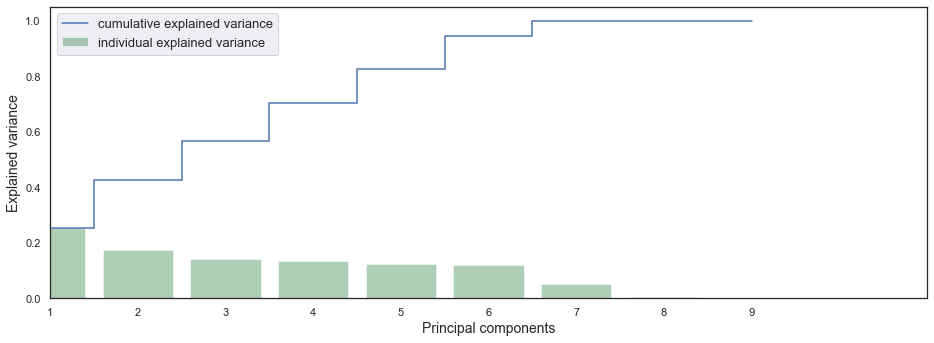

In [89]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

-----
#### 创建客户类别

接下来，我们需要从之前定义的标准化矩阵中定义客户集群，这里使用了scikit-learn中的“k-means”聚类算法。根据轮廓系数选择最佳聚类的簇群数量，最后发现有11个聚类得到了最好的效果。。

In [90]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.224


In [108]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['客户数量']).T

2    1    6    0    9    5    7    8   3   10  4 
客户数量  711  296  219  204  202  150  128  118  15   9   6

PCA

In [92]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

In [102]:
mat

0         1         2         3         4         5  cluster
0     0.480240 -0.551829 -0.386876 -0.539425  0.343109 -0.156832        2
1    -0.548675  1.962328 -0.988134  0.835023 -1.310514 -2.516880        0
2    -0.235560 -1.888515 -0.762867  0.599248  0.005675 -0.482725        1
3     0.256903 -2.186187 -1.533318  0.363945 -2.272964  0.450802        1
4     0.423435 -0.423575  0.464458 -1.179785 -0.722019  0.414594        6
...        ...       ...       ...       ...       ...       ...      ...
2053  0.263386  0.352429  0.108977  0.023314  0.863532 -0.730253        2
2054 -0.586293 -0.025311  3.567277 -3.052943 -0.922244  0.698474        6
2055 -0.723043 -1.063638 -0.109958 -0.161155  2.629687 -1.233975        9
2056 -1.018101 -0.112474 -0.204656  0.005673 -0.250895  0.283100        2
2057 -1.027946  1.224837  1.082865  0.171402 -0.184444 -0.024136        2

[2058 rows x 7 columns]

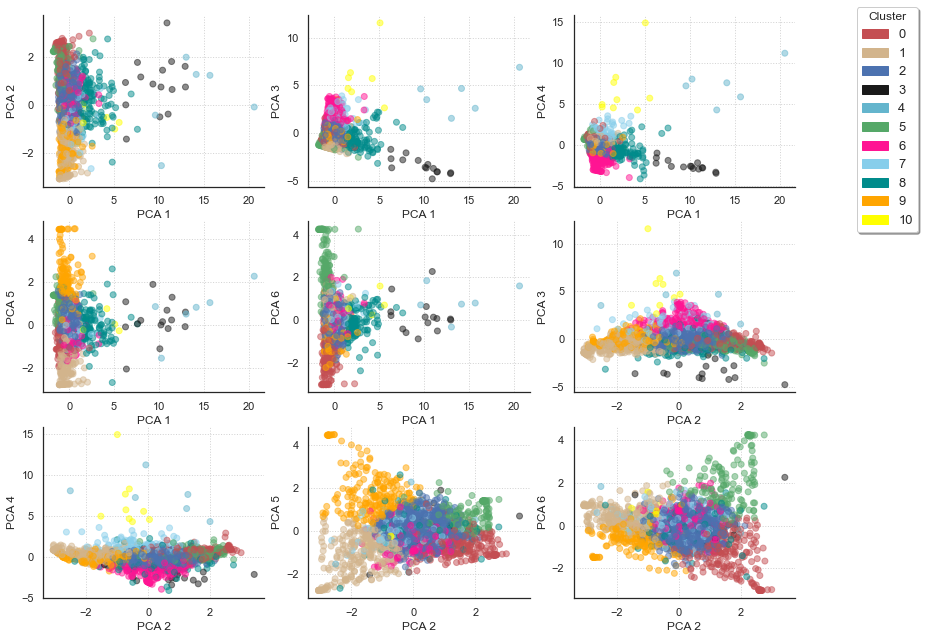

In [101]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan',
                   9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(3,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', 
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure) #facecolor = 'lightgrey',

plt.tight_layout()

silhouette intra-cluster

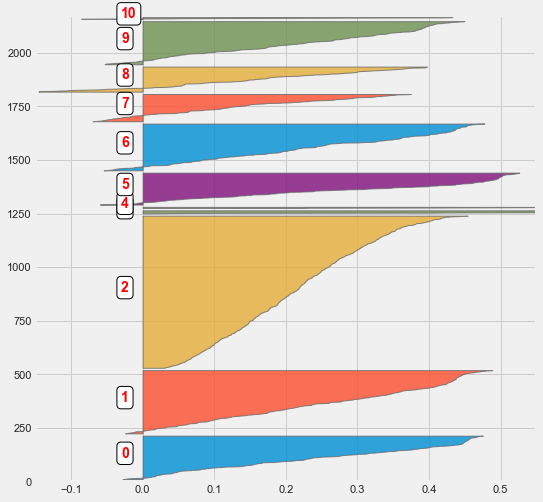

In [103]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silhouette scores 
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, 
                           clusters_clients)

#### 客户形态类型

到目前为止，我们已经验证了不同的集群确实是不相交的(至少在全局方面)。
为了进一步细分客户，了解每个集群中客户的习惯。因此在表'selected_customers'中添加一个变量来定义每个客户端所属的集群。

In [104]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [114]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('客户ID', axis = 1, inplace = True)
print('客户数量:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

客户数量: 2058


In [115]:
merged_df

count          min           max         mean           sum  \
cluster                                                                    
5.0       1.513333   225.383267    277.737200   248.484573    368.741200   
0.0       1.578431   228.836078    289.043534   258.919900    429.732309   
9.0       1.504950   239.305693    342.607970   286.893678    466.588168   
1.0       1.500000   261.862368    353.959733   306.329657    468.080476   
2.0       1.541491   332.245543    435.876359   382.851420    580.136387   
6.0       1.598174   290.049772    397.243653   343.943282    594.670822   
8.0       1.457627  1144.540678   1659.602542  1362.915342   2212.972373   
7.0       5.992188   125.120469    864.530625   415.026017   2561.223437   
3.0       1.000000  3762.531333   3762.531333  3762.531333   3762.531333   
10.0     24.333333   101.770000   2991.165556   565.438524  13438.356667   
4.0      12.666667    71.353333  19052.918333  4562.130528  54109.740000   

           categ_0    categ_1    categ_2    categ_3    categ_4     最后一次购买  \
cluster                                                                     
5.0      17.413154   5.335562  62.801676   5.799072   8.650536  30.773333   
0.0      65.895439   5.321537  10.914599   8.419572   9.490690  36.254902   
9.0      11.869735  53.862170   6.848795  13.855380  13.617020  28.608911   
1.0      11.494680  14.035249   6.210796  57.550068  10.716963  31.432432   
2.0      28.940499  18.422190  16.290377  16.326220  20.024025  27.520394   
6.0      14.693974   7.930926   8.480316   9.314960  59.579824  29.287671   
8.0      26.331552  17.032053  12.749541  20.712083  23.175343  26.322034   
7.0      24.687894  17.171834  14.071288  20.618813  23.514078  10.156250   
3.0      21.315807  19.671913  17.122452  26.218595  15.671234  38.533333   
10.0     23.856268  19.517501  11.406526  23.491252  21.792592   2.222222   
4.0      26.015281  21.699295   9.211459  24.894275  18.179690  11.666667   

             第一次购买  size  
cluster                   
5.0      41.326667   150  
0.0      49.117647   204  
9.0      39.074257   202  
1.0      43.777027   296  
2.0      42.580872   711  
6.0      41.835616   219  
8.0      36.491525   118  
7.0      69.140625   128  
3.0      38.533333    15  
10.0     77.111111     9  
4.0      73.000000     6

In [119]:
merged_df[merged_df['categ_0'] > 45].index.values[0]

0.0

In [120]:
merged_df[merged_df['categ_1'] > 45].index.values[0]

9.0

最后，重新组织数据表中的内容，通过以下方法排序不同的集群：首先，根据每个产品类别中花费的金额排序，然后再根据总花费进行排序。

In [124]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])

liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]

merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

cluster      count          min           max         mean           sum  \
0       0.0   1.578431   228.836078    289.043534   258.919900    429.732309   
1       9.0   1.504950   239.305693    342.607970   286.893678    466.588168   
2       5.0   1.513333   225.383267    277.737200   248.484573    368.741200   
3       1.0   1.500000   261.862368    353.959733   306.329657    468.080476   
4       6.0   1.598174   290.049772    397.243653   343.943282    594.670822   
5       2.0   1.541491   332.245543    435.876359   382.851420    580.136387   
6       8.0   1.457627  1144.540678   1659.602542  1362.915342   2212.972373   
7       7.0   5.992188   125.120469    864.530625   415.026017   2561.223437   
8       3.0   1.000000  3762.531333   3762.531333  3762.531333   3762.531333   
9      10.0  24.333333   101.770000   2991.165556   565.438524  13438.356667   
10      4.0  12.666667    71.353333  19052.918333  4562.130528  54109.740000   

      categ_0    categ_1    categ_2    categ_3    categ_4  size  
0   65.895439   5.321537  10.914599   8.419572   9.490690   204  
1   11.869735  53.862170   6.848795  13.855380  13.617020   202  
2   17.413154   5.335562  62.801676   5.799072   8.650536   150  
3   11.494680  14.035249   6.210796  57.550068  10.716963   296  
4   14.693974   7.930926   8.480316   9.314960  59.579824   219  
5   28.940499  18.422190  16.290377  16.326220  20.024025   711  
6   26.331552  17.032053  12.749541  20.712083  23.175343   118  
7   24.687894  17.171834  14.071288  20.618813  23.514078   128  
8   21.315807  19.671913  17.122452  26.218595  15.671234    15  
9   23.856268  19.517501  11.406526  23.491252  21.792592     9  
10  26.015281  21.699295   9.211459  24.894275  18.179690     6

#### 顾客形态图形表征

最后，创建了不同形态的表现。这里定义了一个类来创建"雷达图"。

In [121]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[0:-1]]
            
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


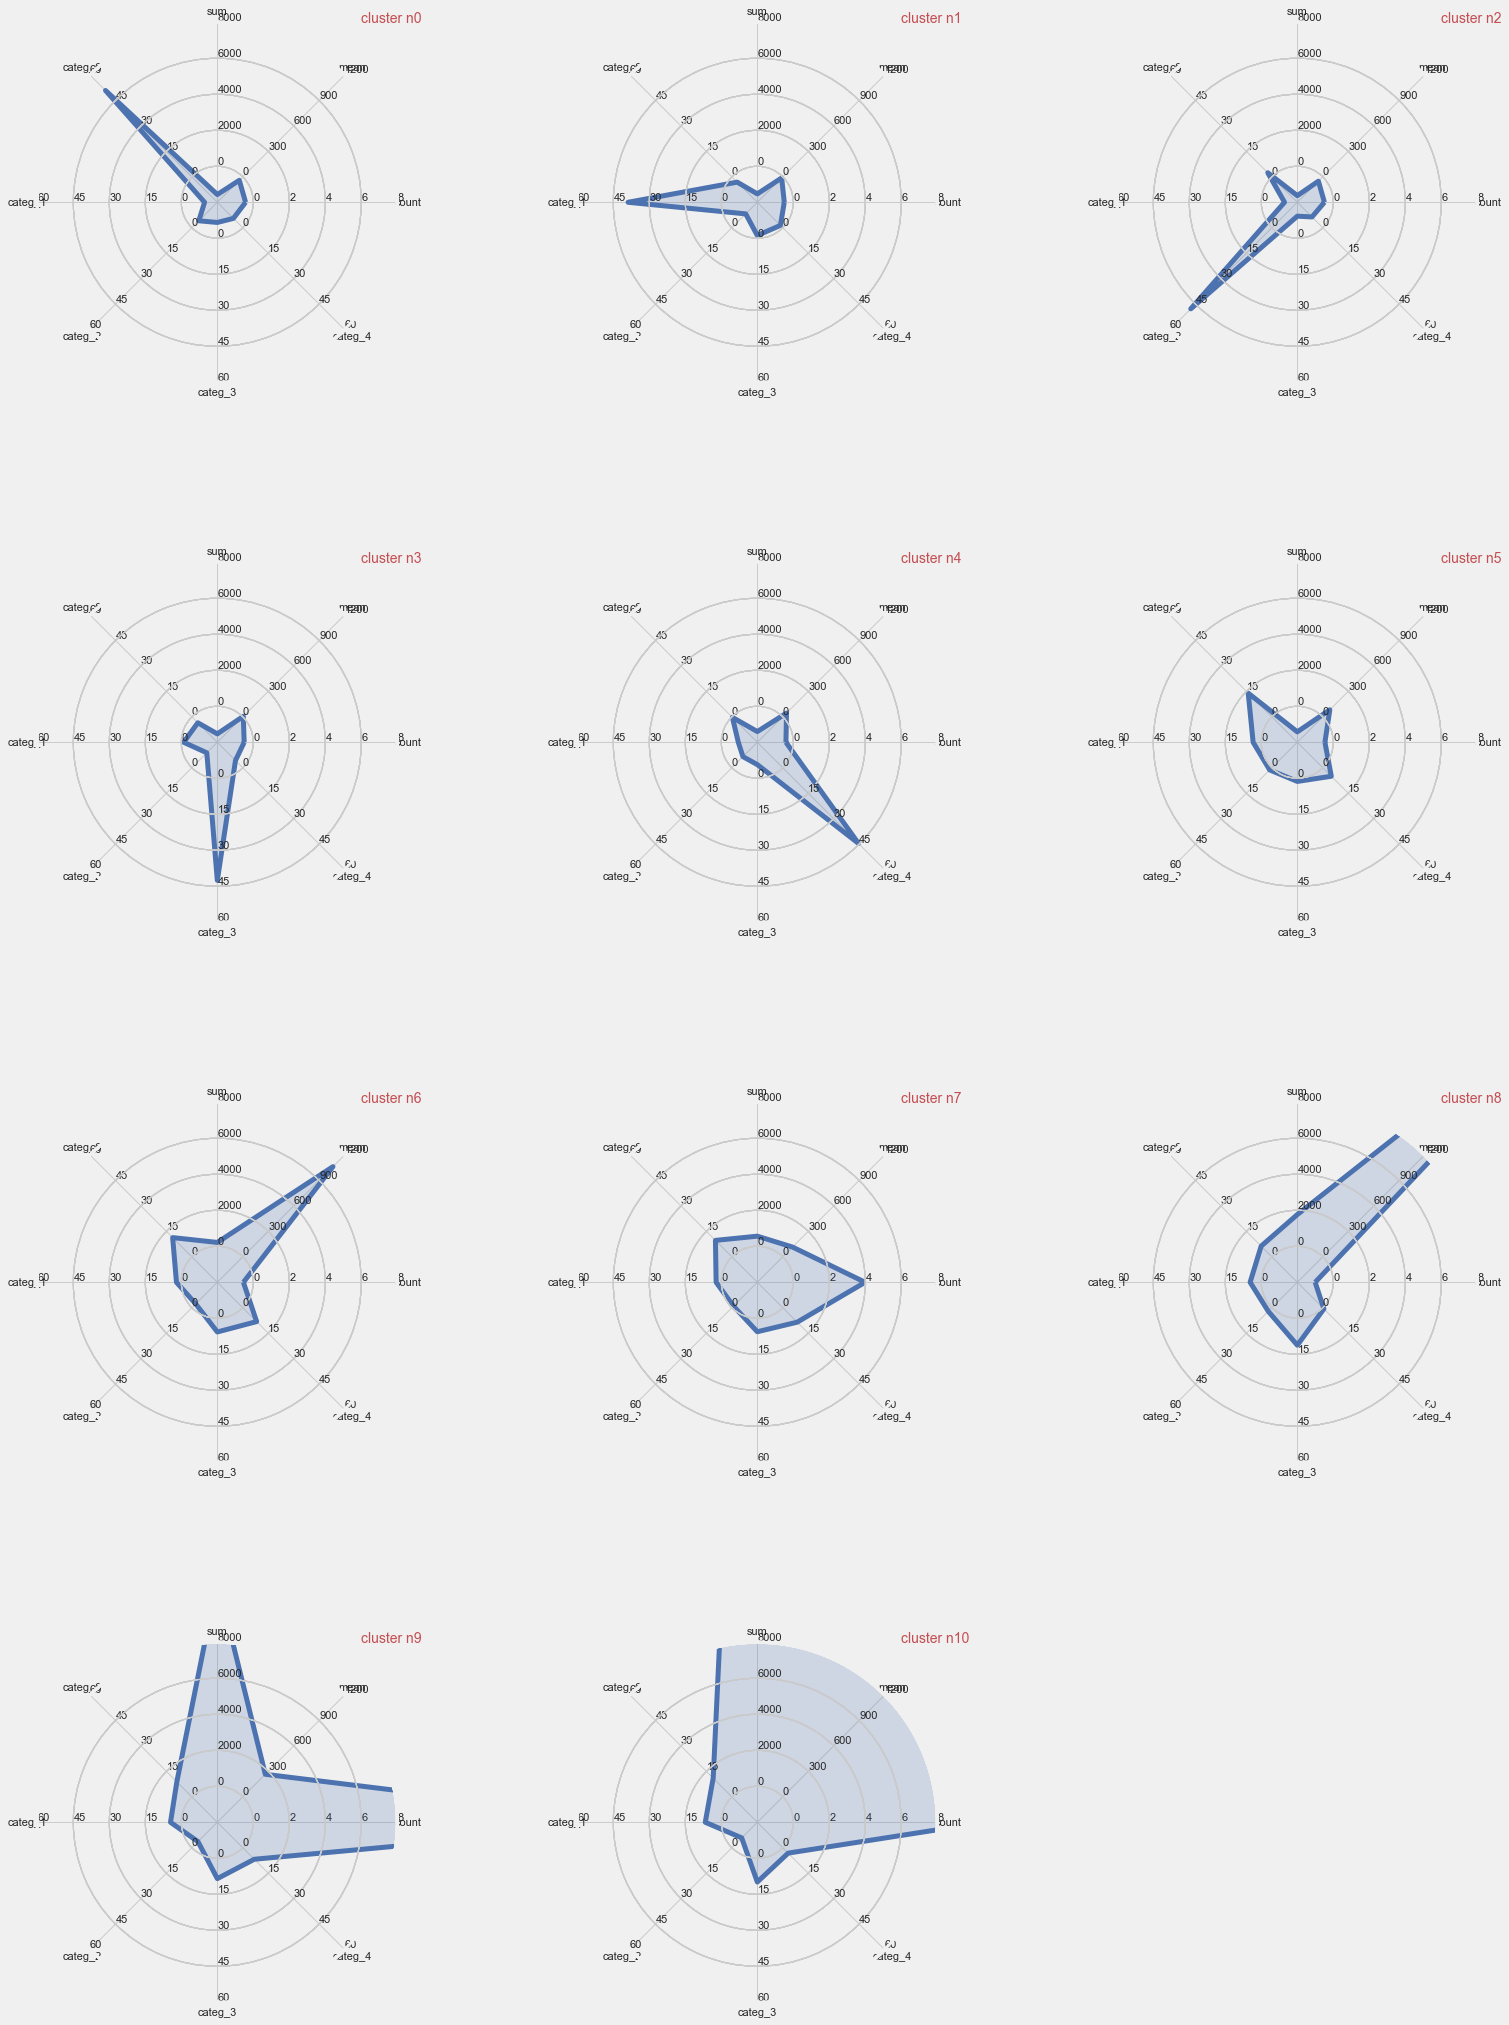

In [126]:
fig = plt.figure(figsize=(50,50))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (0.3/i_cols), (0.3/i_rows)
# size_x, size_y = (i_cols), (i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])  
    #print (data)
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=5.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster n{}'.format(index[ind]), color = 'r')
    ind += 1 


## 客户的分类

在这一部分中，目标是训练一个分类器，该分类器在上一节中建立的不同客户群的类别中将消费者分类。
为了实现这个目标，我将测试"scikit-learn"中的几个分类器。为了简化它们的使用，我定义了一个类，它允许接口这些不同的分类器常见的几个功能。

In [131]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        

### 数据准备

In [132]:
selected_customers.head()

客户ID  count     min     max    mean     sum    categ_0    categ_1  \
0  12347.0      1  584.91  584.91  584.91  584.91  18.755022  27.040057   
1  12348.0      1  310.00  310.00  310.00  310.00  87.096774   0.000000   
2  12352.0      2  266.25  366.25  316.25  632.50  16.110672  33.667984   
3  12358.0      1  484.86  484.86  484.86  484.86  10.469001   3.093677   
4  12360.0      1  534.70  534.70  534.70  534.70  12.537872   9.313634   

     categ_2    categ_3    categ_4  最后一次购买  第一次购买  cluster  
0  10.480245  23.259989  20.464687      59     59        2  
1   0.000000  12.903226   0.000000       5      5        0  
2   0.000000  47.565217   2.656126       2     10        1  
3   0.000000  82.786784   3.650538      80     80        1  
4   8.857303  27.641668  41.649523      42     42        6

In [133]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

将数据集分成训练集和测试集。

In [134]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

___
### 支持向量机分类器(SVC)


创建了一个'Class_Fit'类的实例，然后调用'grid_search()'。当调用这个方法时，需要提供参数

In [135]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [136]:
svc.grid_fit(X = X_train, Y = Y_train)

In [137]:
svc.grid_predict(X_test, Y_test)

Precision: 74.03 % 


___
#### 混淆矩阵

支持向量机的结果的准确性看起来似乎是正确的。但之前定义的类不一定都是平衡的。特别当一个类包含大约40%的客户时。因此这里需要用到评价不平衡数据集所用到的评价指标，即混淆矩阵。

In [138]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
   
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [139]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

Confusion matrix, without normalization



----------------
#### 学习曲线

评价模型拟合质量的一种典型方法是绘制学习曲线。特别是这种类型的学习曲线可以检测模型中可能的不足，例如，检测到模型的过拟合或欠拟合。并且还能看出，模型在较大数据集中得到更好模型效果的可能性。下面绘制这条曲线。

In [145]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure(figsize=(12,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

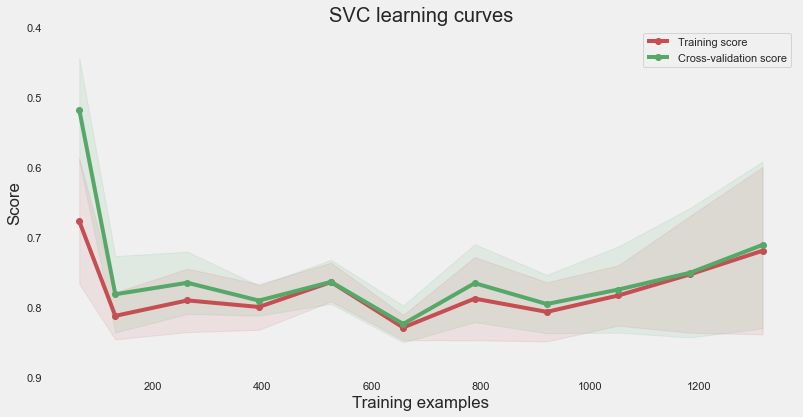

In [150]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", 
                        X_train, Y_train, ylim = [0.9, 0.4],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

## 修改后的方法

### Logistic Regression


现在考虑使用逻辑回归分类器。仍然使用之前创建的一个'Class_Fit'类的实例，并在训练数据上调整模型，并查看预测与实际值的比较。

In [151]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 86.89 % 


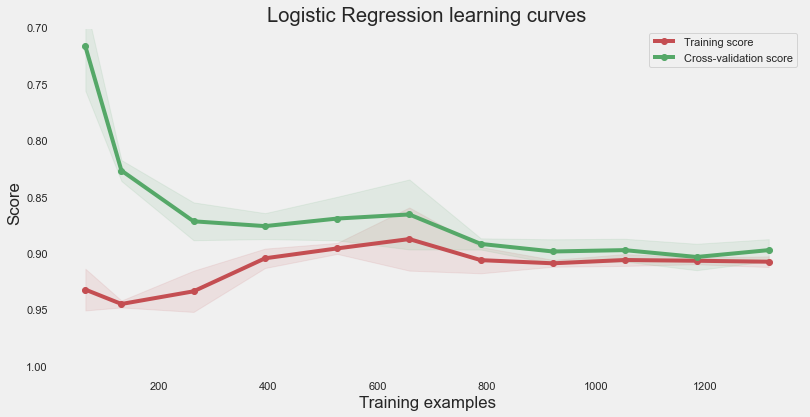

In [152]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

----
### k-Nearest Neighbors

In [153]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 75.73 % 


In [164]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [0.9, 0.3], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Decision Tree

In [155]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 79.85 % 


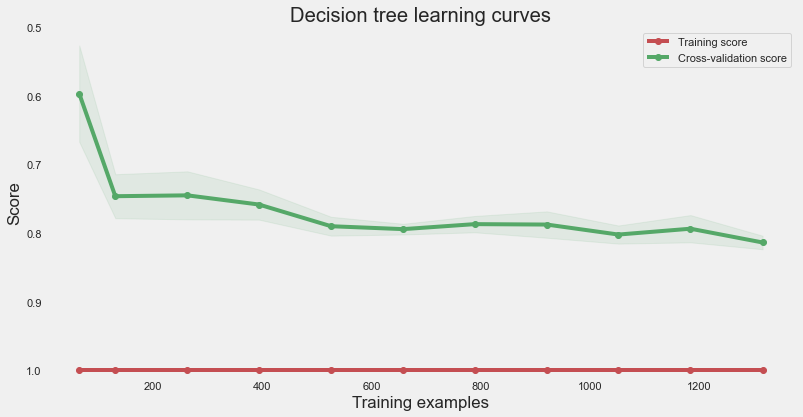

In [167]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.5], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Random Forest

In [157]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 86.17 % 


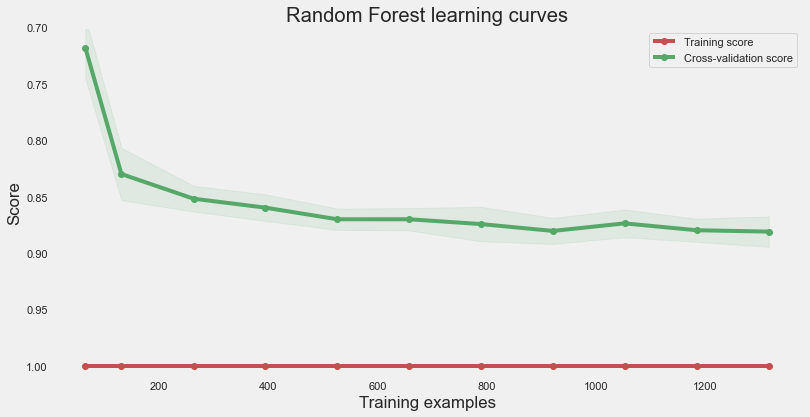

In [158]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### AdaBoost Classifier

In [159]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 47.57 % 


In [168]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [0.9, 0.35], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

###  Gradient Boosting Classifier

In [161]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 85.19 % 


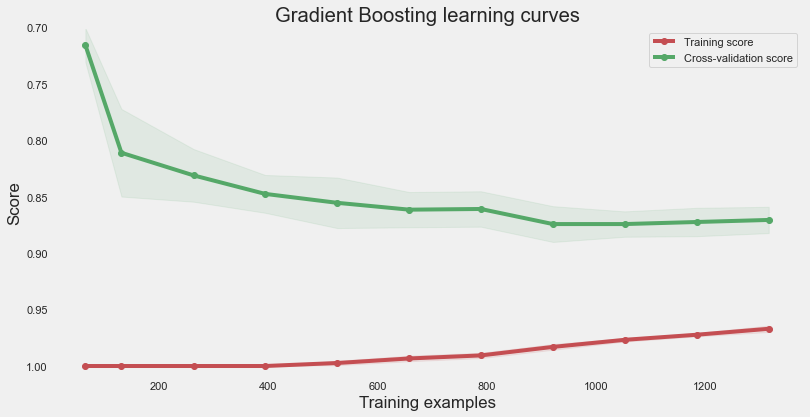

In [162]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


## 投票组合

最后，可以将前面中给出的不同分类器的结果进行组合，以改进分类模型。这可以通过选择大多数分类器所指示的客户类别来实现。这里使用了"sklearn"包的"VotingClassifier"方法

In [169]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [170]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')    

In [171]:
votingC = votingC.fit(X_train, Y_train)

In [172]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 86.41 % 


## Testing predictions

In [173]:
basket_price = set_test.copy(deep = True)

In [174]:
transactions_per_user=basket_price.groupby(by=['客户ID'])['购物车价格'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['客户ID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['客户ID'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('客户ID', ascending = True)[:5]

客户ID  count      min      max     mean       sum    categ_0    categ_1  \
0  12347.0     10   224.82  1294.32   759.57   7595.70  18.675040  26.246429   
1  12349.0      5  1757.55  1757.55  1757.55   8787.75  26.506216  10.875935   
2  12352.0      5   311.73   311.73   311.73   1558.65  34.420813  11.949443   
3  12356.0      5    58.35    58.35    58.35    291.75   0.000000   0.000000   
4  12357.0      5  6207.67  6207.67  6207.67  31038.35  18.601182  26.941832   

     categ_2     categ_3    categ_4  
0  14.039522    8.695709  32.343299  
1   4.513101   46.866376  11.238372  
2   6.672441   42.953838   4.003465  
3   0.000000  100.000000   0.000000  
4   5.341134   33.399810  15.716042

In [175]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols].values
scaled_test_matrix = scaler.transform(matrix_test)
scaled_test_matrix

array([[ 3.48, -0.29,  0.58, ..., -0.09, -0.57,  0.62],
       [ 1.32,  3.37,  0.96, ..., -0.63,  1.3 , -0.51],
       [ 1.32, -0.09, -0.21, ..., -0.51,  1.11, -0.9 ],
       ...,
       [ 1.32, -0.64, -0.4 , ..., -0.52,  0.61,  0.11],
       [12.12, -0.82, -0.21, ..., -0.02, -0.84,  1.57],
       [ 3.48, -0.66,  0.35, ...,  0.62, -1.  ,  0.52]])

In [176]:
Y = kmeans.predict(scaled_test_matrix)

In [177]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

In [178]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 24.11 % 
______________________________ 
Logostic Regression
Precision: 27.56 % 
______________________________ 
k-Nearest Neighbors
Precision: 25.91 % 
______________________________ 
Decision Tree
Precision: 31.48 % 
______________________________ 
Random Forest
Precision: 27.56 % 
______________________________ 
Gradient Boosting
Precision: 27.48 % 


In [179]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 27.56 % 


公众号【数据STUDIO】以Python为核心语言，垂直于数据科学领域，分享大量知识总结及实战项目经验分享，包括数据分析、可视化、机器学习、数据挖掘等领域，从入门到进阶！每篇文章源数据和源码均可免费获取！

![数据STUDIO](http://liuzaoqi.oss-cn-beijing.aliyuncs.com/2021/09/17/shu-justudio.jpg?域名/sample.jpg?x-oss-process=style/stylename)

![](http://liuzaoqi.oss-cn-beijing.aliyuncs.com/2021/09/16/16317972442543.jpg?域名/sample.jpg?x-oss-process=style/stylename)